<a href="https://colab.research.google.com/github/cezary-rasinski/BikeRentalIO/blob/main/olympics_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
data = pd.read_csv("/content/dataset_olympics.csv")

# Przygotowanie danych

In [ ]:
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      70000 non-null  int64  
 1   Name    70000 non-null  object 
 2   Sex     70000 non-null  object 
 3   Age     67268 non-null  float64
 4   Height  53746 non-null  float64
 5   Weight  52899 non-null  float64
 6   Team    70000 non-null  object 
 7   NOC     70000 non-null  object 
 8   Games   70000 non-null  object 
 9   Year    70000 non-null  int64  
 10  Season  70000 non-null  object 
 11  City    70000 non-null  object 
 12  Sport   70000 non-null  object 
 13  Event   70000 non-null  object 
 14  Medal   9690 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 8.0+ MB


Z tego co widać częśc kolumn nie będzie potrzeba do analizy danych. Usunę więc ID, Name (nie wnoszą niczego ważnego) oraz NOC ponieważ jest zbędne skoro mamy już kraje w tabeli TEAM.

In [ ]:
data.drop(columns=['ID', 'Name', 'NOC'], inplace=True)

Zmieniam object data types na category

In [ ]:
categorical_columns = ['Sex', 'Games', 'Season', 'City', 'Sport', 'Event', 'Medal']
for col in categorical_columns:
    data[col] = data[col].astype('category')

Małe zmiany dla lepszej przejrzystośći

In [ ]:
data['Sex'] = data['Sex'].replace({'M': 'Male', 'F': 'Female'})
data['Medal'] = data['Medal'].cat.add_categories('None')
data['Medal'] = data['Medal'].fillna('None')

<ipython-input-118-8499a5e32d19>:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [ ]:
data.head()

,Sex,Age,Height,Weight,Team,Games,Year,Season,City,Sport,Event,Medal
0,Male,24.0,180.0,80.0,China,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,Male,23.0,170.0,60.0,China,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,Male,24.0,NaN,NaN,Denmark,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
3,Male,34.0,NaN,NaN,Denmark/Sweden,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Female,21.0,185.0,82.0,Netherlands,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None


In [ ]:
data.isna().sum() / len(data)

,0
Sex,0.000000
Age,0.039029
Height,0.232200
Weight,0.244300
Team,0.000000
Games,0.000000
Year,0.000000
Season,0.000000
City,0.000000
Sport,0.000000


Sprawdzam procent brakujących wartości, jako że Age brakuje jedynie około 4% mogę te dane usunąć. Jednak braki wzrostu i wagi to ok 20%, więc uznałem że mogę je uzupełnić średnią. Do obliczenia wzrostu biorę średnią wysokość kobiet i mężczyzn z danego kraju.

In [ ]:
data = data.dropna(subset=['Age'])
data['Height'] = data.groupby(['Sex', 'Team'], observed=True)['Height'].transform( lambda x: x.fillna(x.mean()))

In [ ]:
data.isna().sum() / len(data)

,0
Sex,0.000000
Age,0.000000
Height,0.009053
Weight,0.218276
Team,0.000000
Games,0.000000
Year,0.000000
Season,0.000000
City,0.000000
Sport,0.000000


Usuwam małą resztkę null wartości

In [ ]:
data = data.dropna(subset=['Height'])

Do obliczenia średniej wagi, tworzę 'biny' wzrostu, i na ich podstawie liczę średnią wagę kobiet i mężczyzn z każdej grupy.
Najpierw sprawdzam min i max wzrosty żeby wiedzieć jaki range binów zrobić

In [ ]:
data['Height'].describe()

,Height
count,66659.000000
mean,175.986967
std,9.582028
min,127.000000
25%,170.000000
50%,177.000000
75%,182.000000
max,223.000000


In [ ]:
bins = np.arange(120, 230, 15)
data['Height_Bin'] = pd.cut(data['Height'], bins=bins)
data['Weight'] = data.groupby(['Sex', 'Height_Bin'])['Weight'].transform(lambda x: x.fillna(x.mean()))
data = data.drop(columns=['Height_Bin'])

<ipython-input-126-1c4b2917001b>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
data.isnull().sum()

,0
Sex,0
Age,0
Height,0
Weight,0
Team,0
Games,0
Year,0
Season,0
City,0
Sport,0


Sprawdzam teraz czy są jakieś duplikaty, i jeśli tak to je usuwam

In [ ]:
data.duplicated().sum()

806

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.describe()

,Age,Height,Weight,Year
count,65853.000000,65853.000000,65853.000000,65853.000000
mean,25.504427,175.959616,71.470845,1980.602676
std,6.203657,9.623607,13.188610,28.068118
min,11.000000,127.000000,25.000000,1896.000000
25%,21.000000,170.000000,63.000000,1964.000000
50%,24.000000,177.000000,71.064153,1988.000000
75%,28.000000,182.000000,80.000000,2004.000000
max,88.000000,223.000000,214.000000,2016.000000


Można stworzyć nowe kolumy, np. BMI oraz przypisać zawodnikow do różnych grup wiekowych

In [ ]:
data['BMI'] = data['Weight'] / (data['Height'] / 100) ** 2
bins = [0, 18, 25, 35, 50, 100]
labels = ['Teenager', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)

In [ ]:
data.head()

,Sex,Age,Height,Weight,Team,Games,Year,Season,City,Sport,Event,Medal,BMI,Age_Group
0,Male,24.0,180.000000,80.00000,China,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,24.691358,Young Adult
1,Male,23.0,170.000000,60.00000,China,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,20.761246,Young Adult
2,Male,24.0,182.027559,83.14081,Denmark,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,25.092271,Young Adult
4,Female,21.0,185.000000,82.00000,Netherlands,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,23.959094,Young Adult
5,Female,21.0,185.000000,82.00000,Netherlands,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",None,23.959094,Young Adult


# EDA


Z ciekawości spójrzmy na BMI olimpijczyków

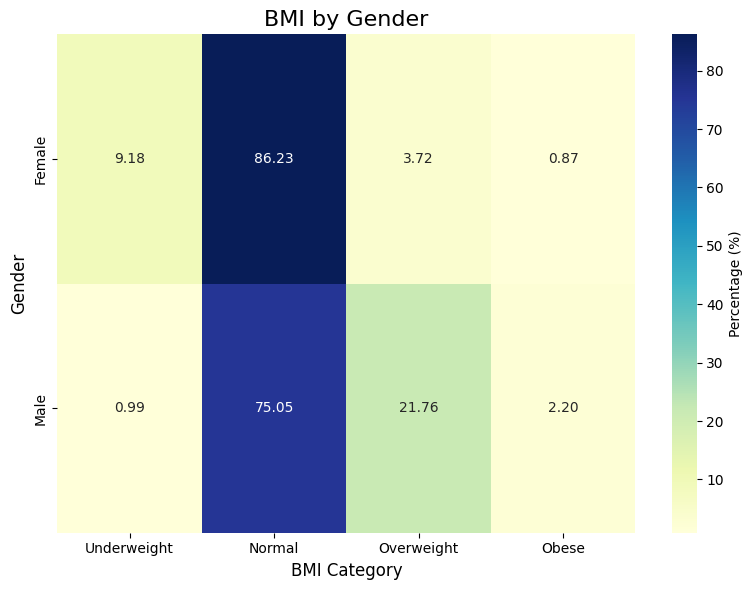

In [ ]:
bins = [0, 18.5, 25, 30, np.inf]
labels = ["Underweight", "Normal", "Overweight", "Obese"]

data['BMI_Category'] = pd.cut(data['BMI'], bins=bins, labels=labels)

grouped = data.groupby(['Sex', 'BMI_Category'], observed=True).size().unstack(fill_value=0)

grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

grouped_pct_rounded = grouped_pct.round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(
    grouped_pct_rounded,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage (%)'}
)

plt.title("BMI by Gender", fontsize=16)
plt.xlabel("BMI Category", fontsize=12)
plt.ylabel("Gender", fontsize=12)
plt.tight_layout()

plt.show()

Można wnioskować że BMI nie koniecznie jest dokładnym wyznacznikiem 'stanu zdrowia'. Cięzko powiedzieć o osobie która bierze udział w igrzyzskach, że ma nadwagę lub złą formę, co sugerowałoby 'zły' styl życia.

Teraz na podstaie boxplotów zobaczmy jak rozkładają się 'statystyki' zawodników.

In [ ]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Box(y=data['Age'], name="Age", boxmean=True, marker_color='skyblue'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=data['Height'], name="Height", boxmean=True, marker_color='lime'),
    row=2, col=1
)

fig.add_trace(
    go.Box(y=data['Weight'], name="Weight", boxmean=True, marker_color='salmon'),
    row=3, col=1
)
fig.update_layout(
    height=900,
    width=800,
    title_text="Boxplots for Age, Height, and Weight",
    title_x=0.5,
    showlegend=True
)

fig.show()

Jak widać mimo dużej różnorodności dyscyplin, większośc aspektów fizycznych zawodników mieści się w w niewielkim przedziale. Można też zobaczyć jak to wygląda przy podzieleniu zawodnikó ma płeć.

In [ ]:
fig = make_subplots(
    rows=3, cols=2,
    shared_yaxes=True
)

male_data = data[data['Sex'] == 'Male']
female_data = data[data['Sex'] == 'Female']

fig.add_trace(
    go.Box(y=male_data['Age'], name="Male", boxmean=True, marker_color='skyblue'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=female_data['Age'], name="Female", boxmean=True, marker_color='pink'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=male_data['Height'], name="Male", boxmean=True, marker_color='lightgreen'),
    row=2, col=1
)

fig.add_trace(
    go.Box(y=female_data['Height'], name="Female", boxmean=True, marker_color='lightcoral'),
    row=2, col=2
)

fig.add_trace(
    go.Box(y=male_data['Weight'], name="Male", boxmean=True, marker_color='salmon'),
    row=3, col=1
)

fig.add_trace(
    go.Box(y=female_data['Weight'], name="Female", boxmean=True, marker_color='gold'),
    row=3, col=2
)

fig.update_layout(
    height=1200,
    width=1000,
    title_text="Boxplots for Age, Height, and Weight (Male and Female)",
    title_x=0.5,
    showlegend=True
)

fig.show()

Rozkład dla mężczyzn i kobiet jest bardzo podobny w każdej kategorii, oraz naturalnie w każdej kategorii kobiety mają niższe 'statystyki'. Zakładam również że brzegowe wartości mogą być związane z specyficznymi sportami więc sprawdźmy.

In [ ]:
average_height_per_sport = data.groupby('Sport')['Height'].mean().dropna()
sorted_sports_by_height = average_height_per_sport.sort_values()

lowest_5_sports = sorted_sports_by_height.head(5)
highest_5_sports = sorted_sports_by_height.tail(5)
top_and_bottom_sports = pd.concat([lowest_5_sports, highest_5_sports])
top_and_bottom_sports

<ipython-input-49-2d5295184464>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Height
Sport,
Trampolining,165.714286
Gymnastics,166.254055
Rhythmic Gymnastics,166.748838
Synchronized Swimming,167.718802
Diving,168.739977
Rowing,183.366679
Water Polo,183.616468
Beach Volleyball,186.830842
Volleyball,186.883283


Wyniki są całkiem logiczne, osoby wysokie mają lepsze predyspozycje do koszykówki i sportów tego typu, a osoby niskie do gimnastyki oraz nurkowania.
Można zobaczyć jak w każdym z tych sportów ma się średni wzrost do ilości złotych medali olimpijskich

<ipython-input-71-4be6114509da>:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



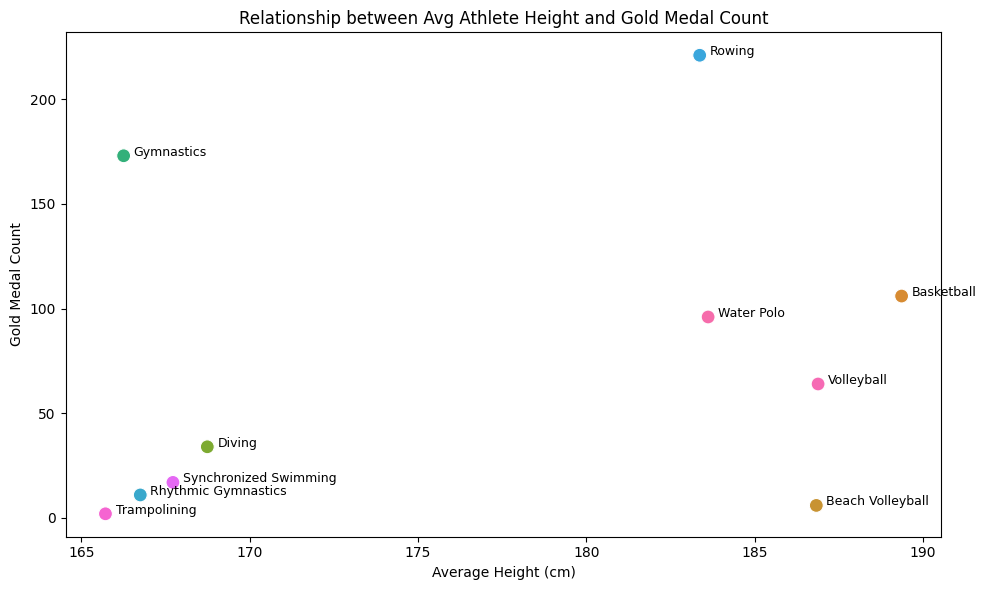

In [ ]:
sports_of_interest = [
    "Trampolining",
    "Gymnastics",
    "Rhythmic Gymnastics",
    "Synchronized Swimming",
    "Diving",
    "Rowing",
    "Water Polo",
    "Beach Volleyball",
    "Volleyball",
    "Basketball"
]

df_sports = data[data['Sport'].isin(sports_of_interest)].copy()

df_sports['GoldIndicator'] = (df_sports['Medal'] == 'Gold').astype(int)

grouped = df_sports.groupby('Sport', as_index=False).agg({
    'Height': 'mean',
    'GoldIndicator': 'sum'
})

grouped.rename(columns={'Height': 'AvgHeight', 'GoldIndicator': 'GoldCount'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    legend=False,
    x='AvgHeight',
    y='GoldCount',
    hue='Sport',
    s=100
)

plt.title("Relationship between Avg Athlete Height and Gold Medal Count")
plt.xlabel("Average Height (cm)")
plt.ylabel("Gold Medal Count")


for i, row in grouped.iterrows():
    plt.text(
        x=row['AvgHeight']+0.3,
        y=row['GoldCount']+0.1,
        s=row['Sport'],
        fontsize=9
    )

plt.tight_layout()
plt.show()

Widoczne jest że wzrost w tych dyscyplinach ma związek z tym jak sobie radzi zawodnik. Można więc uznać wcześniejszą tezę za prawdziwą.

Teraz zobaczmy rozkład uczestnictwa we wszystkich sportach olimpijskich

<ipython-input-50-c0811b06310d>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




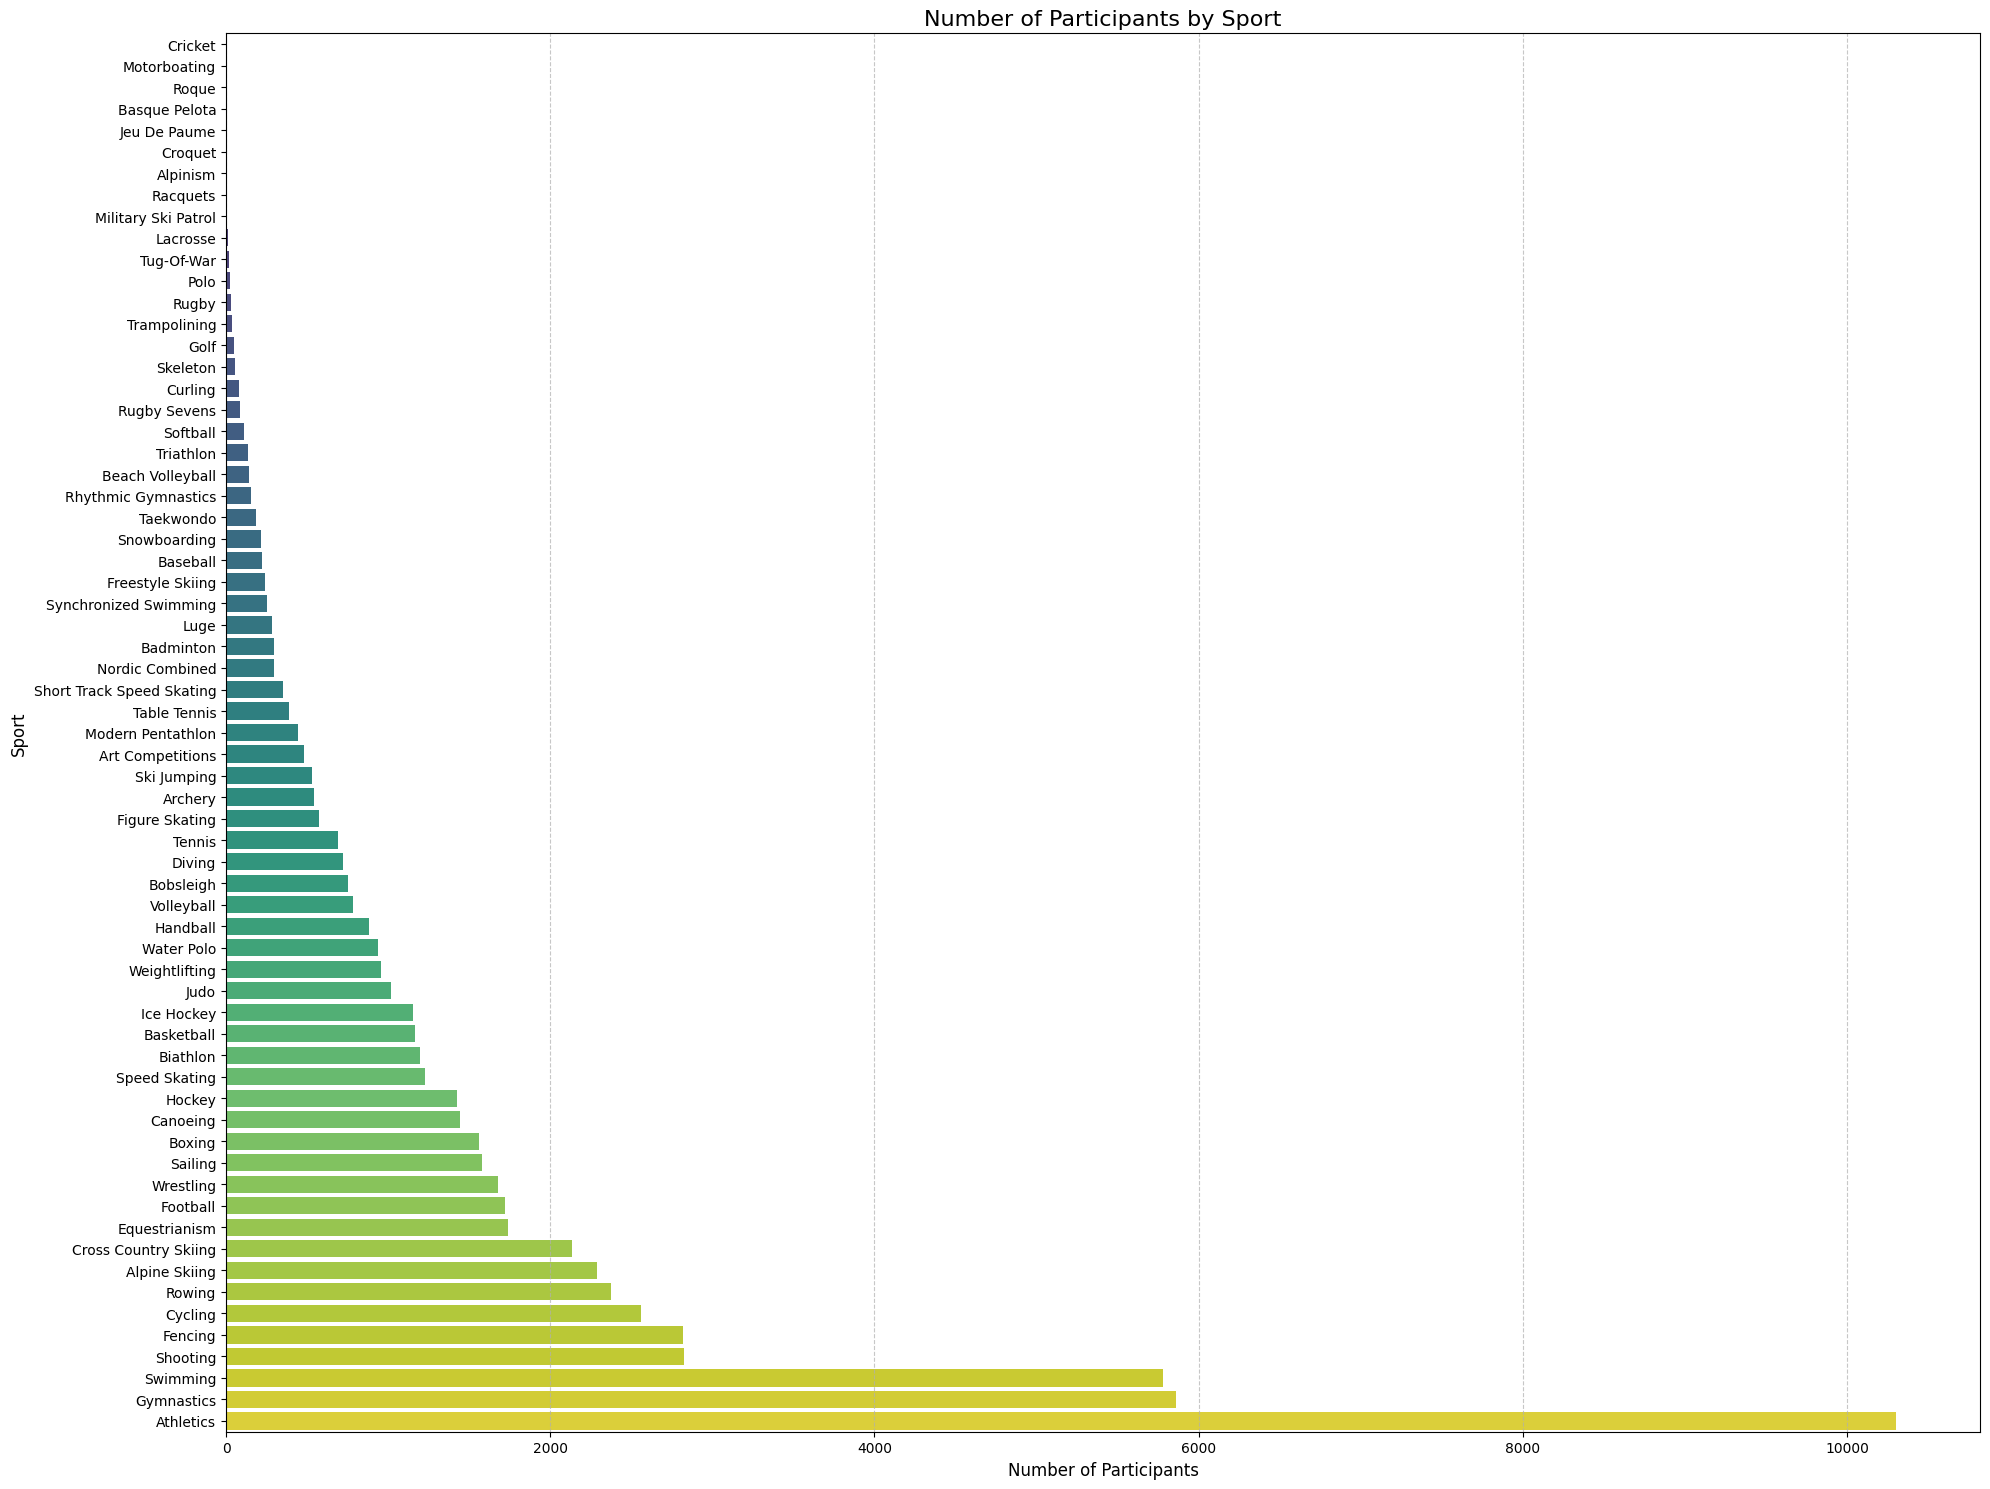

In [ ]:
sport_counts = data['Sport'].value_counts(ascending=True)

plt.figure(figsize=(20, 15))
sns.barplot(
    x=sport_counts.values,
    y=sport_counts.index,
    palette='viridis',
    order=sport_counts.index
)

plt.title('Number of Participants by Sport', fontsize=16)
plt.xlabel('Number of Participants', fontsize=12)
plt.ylabel('Sport', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Jak widać absolutnie dominują sporty lekkoatletyczne, co oczywiście ma sens jako że po pierwsze do tej grupy zalicza się bardzo wiele różnych sportów. Np. kilka kategori biegów na krótkie dystanse.

Teraz zobaczmy procentowy udział Top sportów

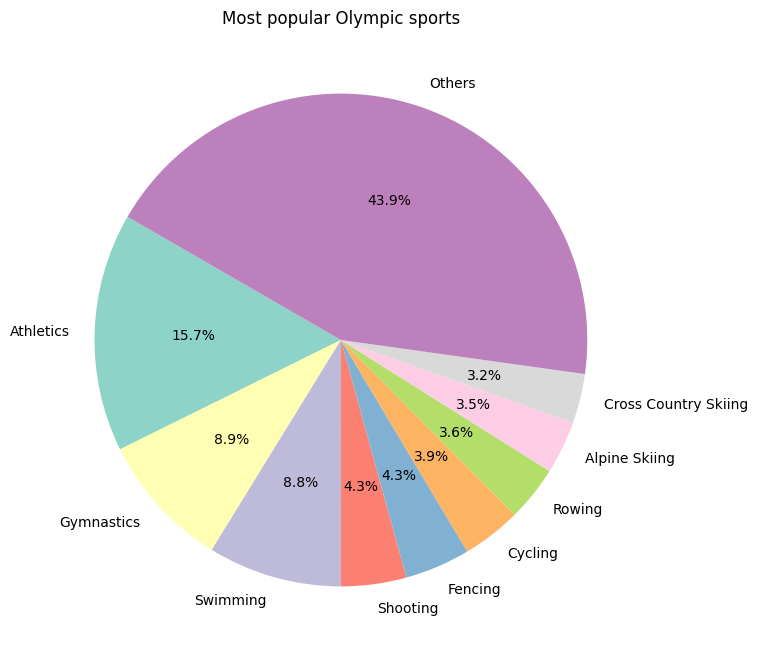

In [ ]:
sport_counts = data['Sport'].value_counts()
top_9 = sport_counts[:9]

others_sum = sport_counts[9:].sum()

top_9['Others'] = others_sum

colors = sns.color_palette("Set3", n_colors=len(top_9))

plt.figure(figsize=(8, 8))
plt.pie(
    top_9,
    labels=top_9.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=150
)

plt.title('Most popular Olympic sports')
plt.show()

Jak widać zaledwie 3 kategorie stanowią aż ok. 1/3 wszystkich sportów na igrzyskach olimpijskich

<ipython-input-52-51f04d26fc85>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




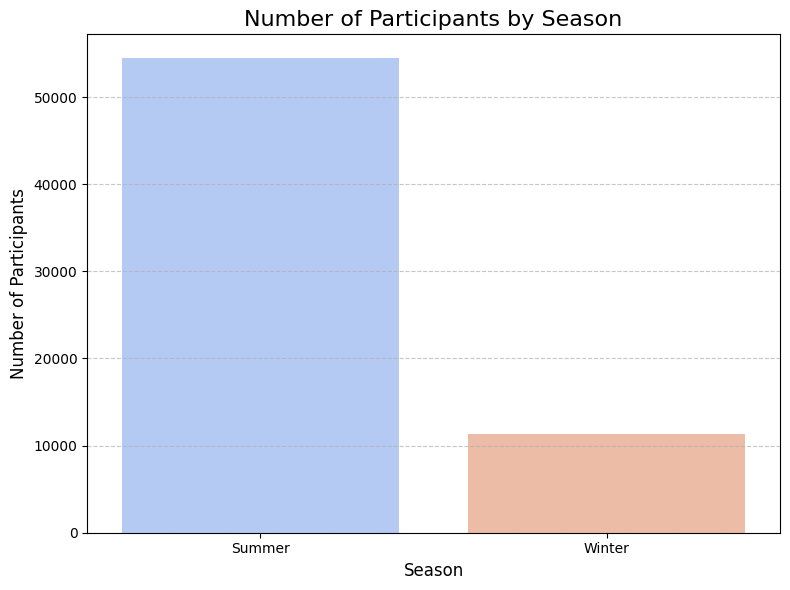

In [ ]:
season_counts = data['Season'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(
    x=season_counts.index,
    y=season_counts.values,
    palette='coolwarm'
)

plt.title('Number of Participants by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Jak widać, pod względem uczestników zdecydowanie dominują sporty letnie

Teraz popatrzmy na różne zależności związane z medalami olimpijskimi

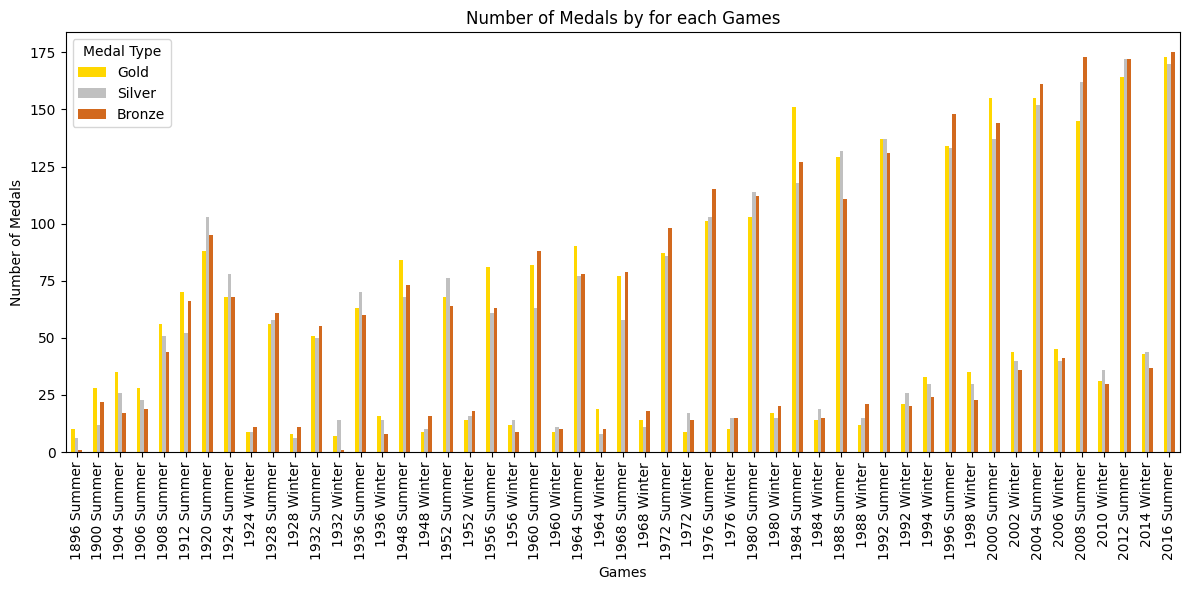

In [ ]:
medals_by_games = data.groupby(["Games", "Medal"], observed=True).size().unstack(fill_value=0)


medals_by_games = medals_by_games[["Gold", "Silver", "Bronze"]]

ax = medals_by_games.plot(
    kind="bar",
    stacked=False,
    figsize=(12, 6),
    color=["gold", "silver", "chocolate"]
)

plt.title("Number of Medals by for each Games")
plt.xlabel("Games")
plt.ylabel("Number of Medals")
plt.legend(title="Medal Type")

plt.tight_layout()
plt.show()

Ciekawe jest to że w niektórych igrzyskach, różnice między ilością poszczególnych medali są całkiem spore. Szczegółnie w oczy rzucają się Summer Olympics z 1984 r. Zobaczmy jednak jak to wygląda procentowo ogółem

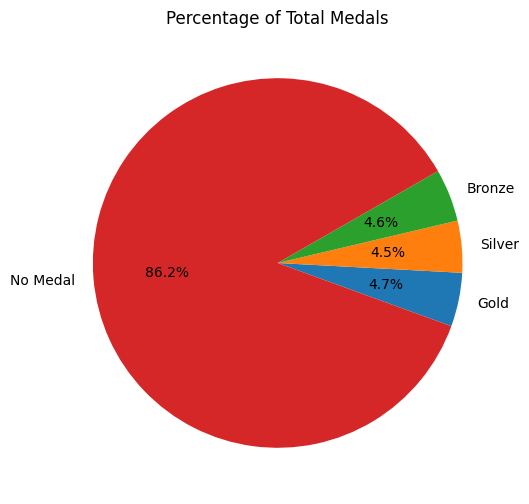

In [ ]:
gold_count = (data['Medal'] == 'Gold').sum()
silver_count = (data['Medal'] == 'Silver').sum()
bronze_count = (data['Medal'] == 'Bronze').sum()
no_medal_count = (data['Medal'] == 'None').sum()

labels = ['Gold', 'Silver', 'Bronze', 'No Medal']
sizes = [gold_count, silver_count, bronze_count, no_medal_count]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=-20
)
plt.title("Percentage of Total Medals")
plt.show()

Jednak w skali całkowitej ratio jest prawie identyczne

Zobaczmy teraz 10 krajów z największą łączną ilością medali

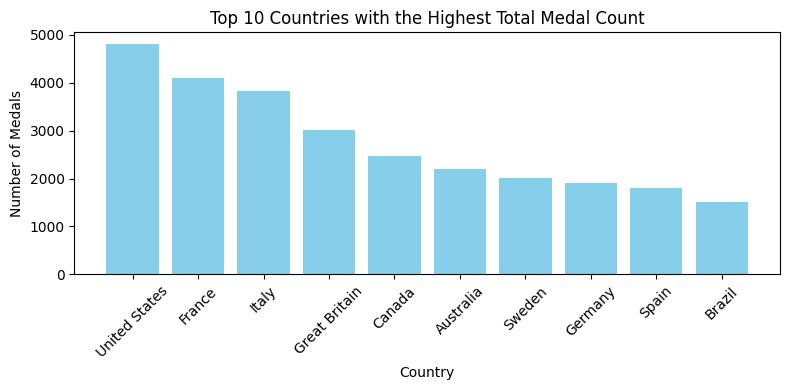

In [ ]:
df_grouped = (
    data
    .dropna(subset=['Medal'])
    .groupby('Team', as_index=False)['Medal']
    .count()
    .rename(columns={'Medal': 'TotalMedals'})
)

df_top_10 = df_grouped.nlargest(10, 'TotalMedals')

plt.figure(figsize=(8,4))
plt.bar(df_top_10['Team'], df_top_10['TotalMedals'], color='skyblue')
plt.title("Top 10 Countries with the Highest Total Medal Count")
plt.xlabel("Country")
plt.ylabel("Number of Medals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Zobaczmy jak ma się to na gdy wyodrębnimy poszczególne medale

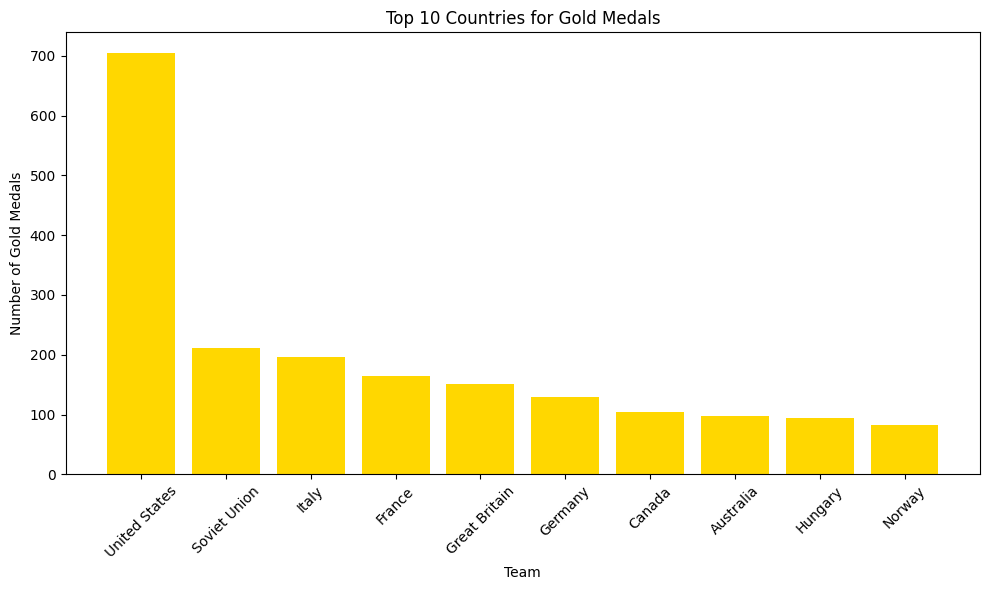

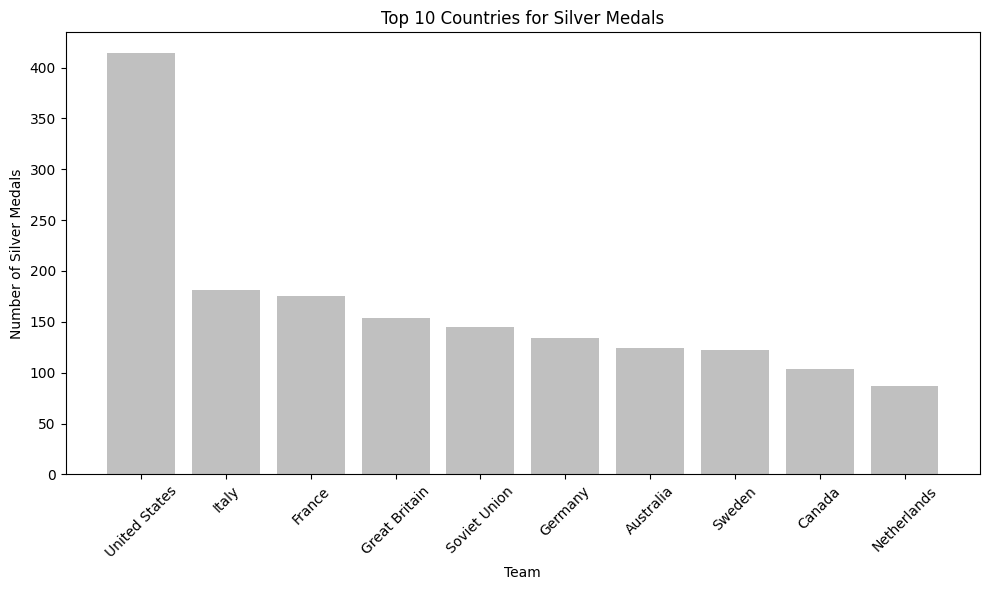

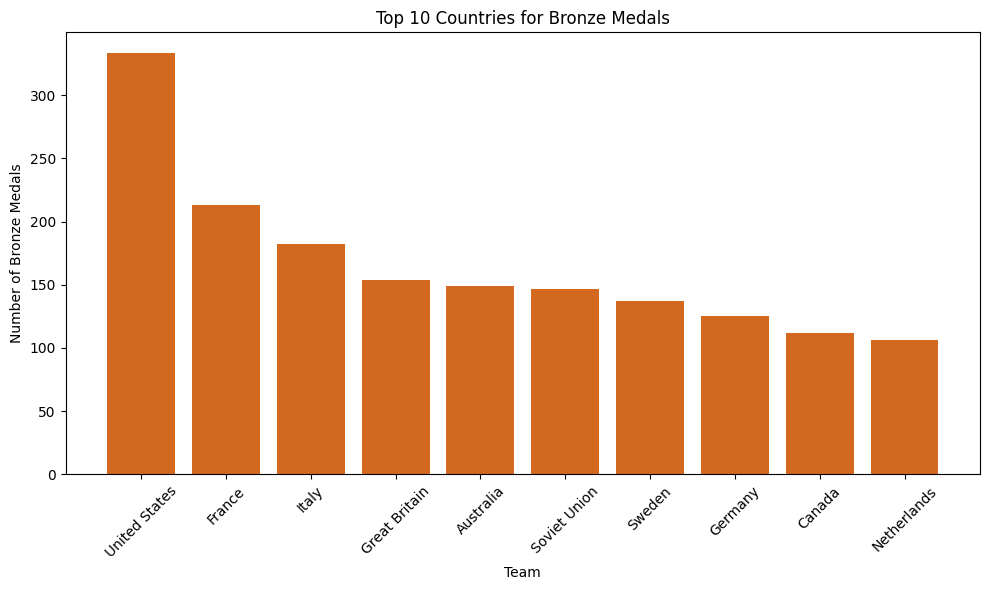

In [ ]:
gold_df = data[data['Medal'] == 'Gold']
gold_grouped = gold_df.groupby('Team', as_index=False)['Medal'].count()
gold_grouped.rename(columns={'Medal': 'GoldCount'}, inplace=True)

top10_gold = gold_grouped.nlargest(10, 'GoldCount')

plt.figure(figsize=(10, 6))
plt.bar(top10_gold['Team'], top10_gold['GoldCount'], color='gold')
plt.title("Top 10 Countries for Gold Medals")
plt.xlabel("Team")
plt.ylabel("Number of Gold Medals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

silver_df = data[data['Medal'] == 'Silver']
silver_grouped = silver_df.groupby('Team', as_index=False)['Medal'].count()
silver_grouped.rename(columns={'Medal': 'SilverCount'}, inplace=True)

top10_silver = silver_grouped.nlargest(10, 'SilverCount')

plt.figure(figsize=(10, 6))
plt.bar(top10_silver['Team'], top10_silver['SilverCount'], color='silver')
plt.title("Top 10 Countries for Silver Medals")
plt.xlabel("Team")
plt.ylabel("Number of Silver Medals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

bronze_df = data[data['Medal'] == 'Bronze']
bronze_grouped = bronze_df.groupby('Team', as_index=False)['Medal'].count()
bronze_grouped.rename(columns={'Medal': 'BronzeCount'}, inplace=True)

top10_bronze = bronze_grouped.nlargest(10, 'BronzeCount')

plt.figure(figsize=(10, 6))
plt.bar(top10_bronze['Team'], top10_bronze['BronzeCount'], color='chocolate')
plt.title("Top 10 Countries for Bronze Medals")
plt.xlabel("Team")
plt.ylabel("Number of Bronze Medals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-134-4cde9d2f4f36>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



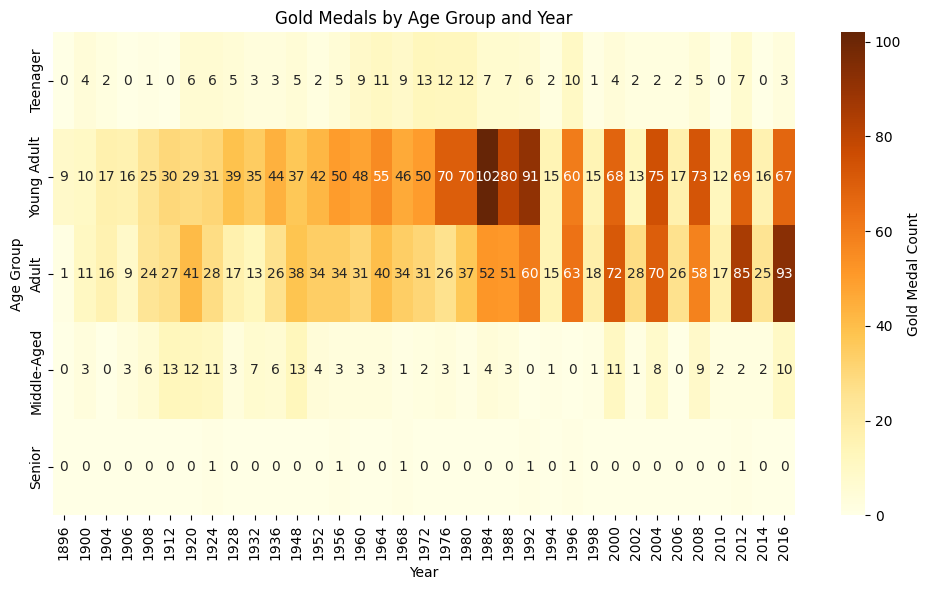

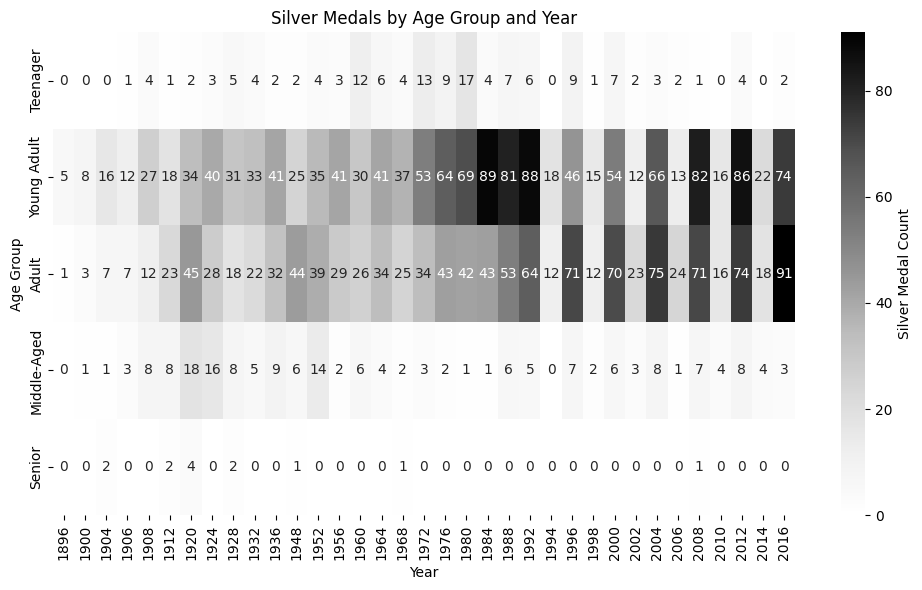

<ipython-input-134-4cde9d2f4f36>:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



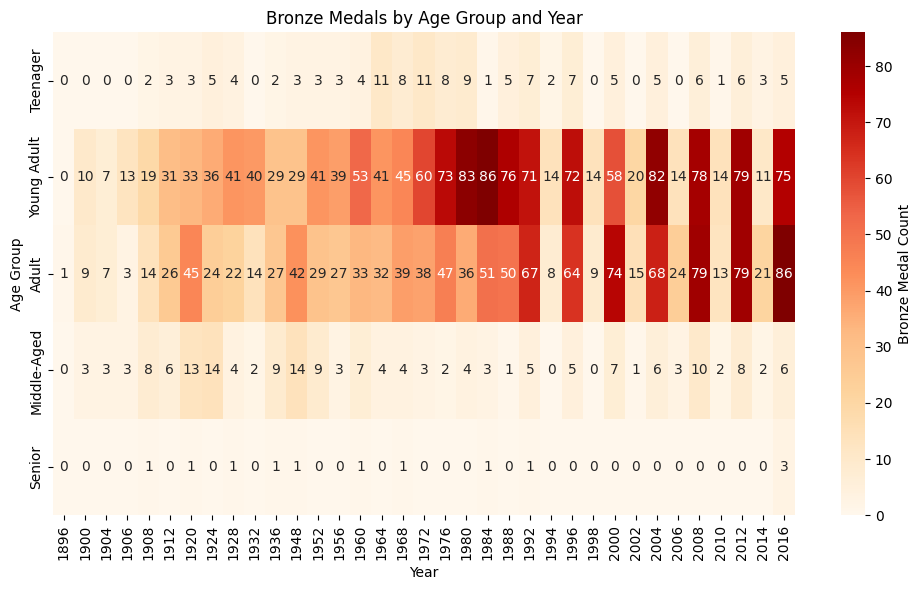

In [ ]:
df_gold = data[data['Medal'] == 'Gold']
grouped_gold = df_gold.groupby(['Age_Group', 'Year'])['Medal'].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    grouped_gold,
    annot=True,
    fmt='d',
    cmap='YlOrBr',     #
    cbar_kws={'label': 'Gold Medal Count'}
)
plt.title("Gold Medals by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

df_silver = data[data['Medal'] == 'Silver']
grouped_silver = df_silver.groupby(['Age_Group', 'Year'], observed=True)['Medal'].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    grouped_silver,
    annot=True,
    fmt='d',
    cmap='Greys',
    cbar_kws={'label': 'Silver Medal Count'}
)
plt.title("Silver Medals by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

df_bronze = data[data['Medal'] == 'Bronze']
grouped_bronze = df_bronze.groupby(['Age_Group', 'Year'])['Medal'].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    grouped_bronze,
    annot=True,
    fmt='d',
    cmap='OrRd',
    cbar_kws={'label': 'Bronze Medal Count'}
)
plt.title("Bronze Medals by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

Teraz mamy 3 heatmaps dla grup wiekowych i lat w których odbywały się igrzyska. Wyraźnie widać że najwięcej medali zdobywają osoby z grup Young Adult (18-25) oraz Adult (25 -35). Widać również na podstawie medali od kiedy igrzyska letnie i zimowe zaczęły się odbywać osobno (1992). Widać też że w igrzyskach zimowych ilośc zdobytych medali jest znacznie mniejsza niż letnich co jest faktem dużo mniejszej ilości dyscyplin. Można też sie upewnić korzystając z pie chart'a.

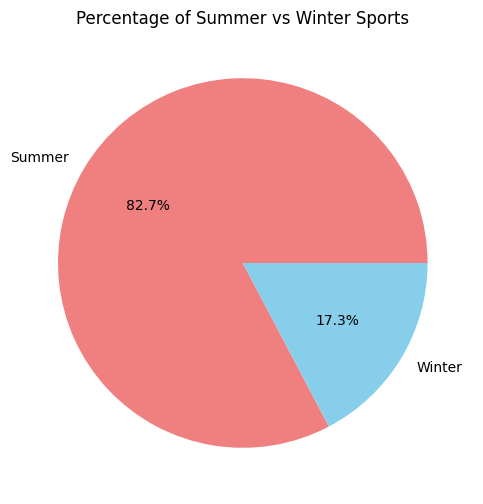

In [ ]:
season_counts = data['Season'].value_counts()

labels = season_counts.index
sizes = season_counts.values
colors = ['lightcoral','skyblue']

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=0
)

plt.title("Percentage of Summer vs Winter Sports")
plt.show()

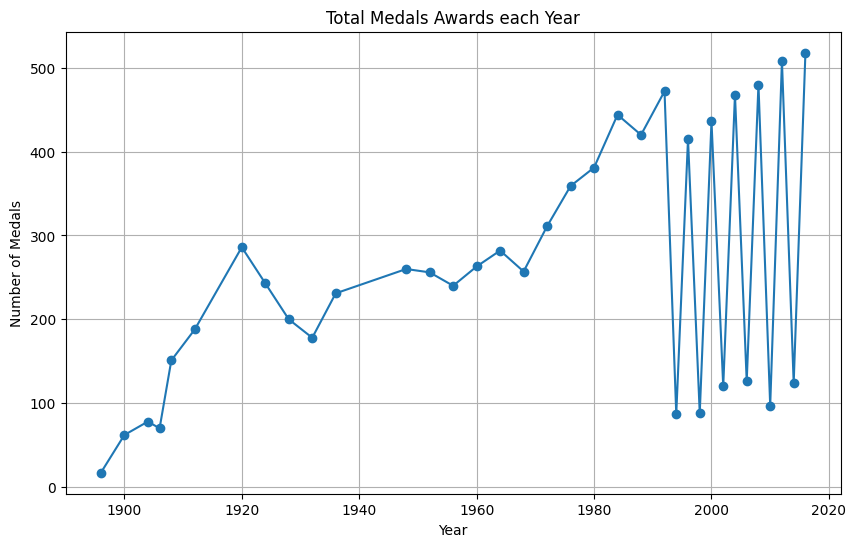

In [ ]:
df_medals = data[data['Medal'] != 'None']

medals_per_year = df_medals.groupby("Year")["Medal"].count().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(medals_per_year.index, medals_per_year.values, marker='o', linestyle='-')
plt.title("Total Medals Awards each Year")
plt.xlabel("Year")
plt.ylabel("Number of Medals")
plt.grid(True)
plt.show()

Przejście na osobne igrzyska co dwa lata widać jeszcze wyraźniej patrząc na sume przyznawanych medali w latach z data setu.

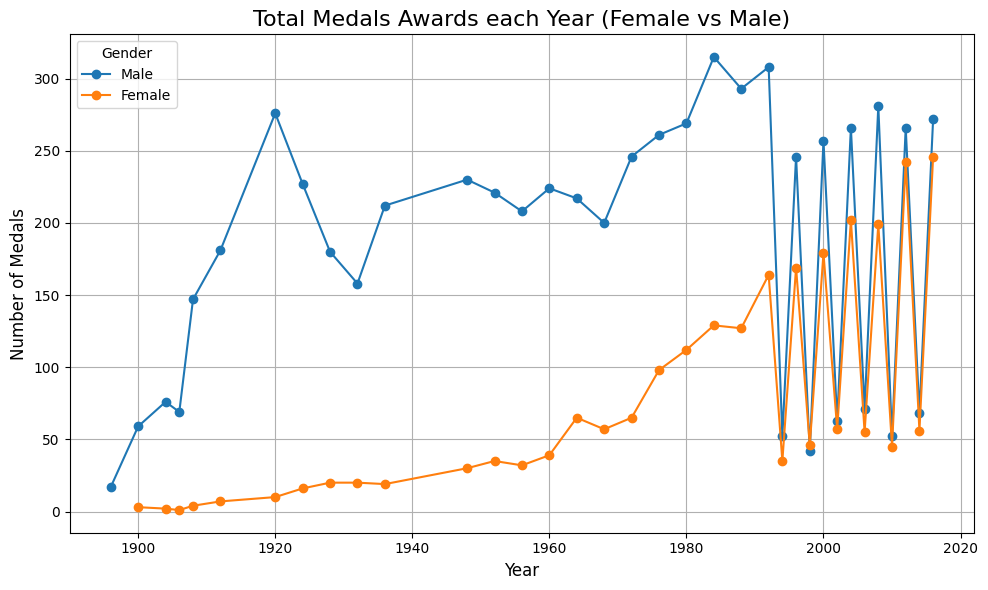

In [ ]:
df_medals = data[data['Medal'] != 'None']

male_medals_per_year = df_medals[df_medals['Sex'] == 'Male'].groupby("Year")["Medal"].count().sort_index()
female_medals_per_year = df_medals[df_medals['Sex'] == 'Female'].groupby("Year")["Medal"].count().sort_index()

plt.figure(figsize=(10, 6))

plt.plot(male_medals_per_year.index, male_medals_per_year.values, marker='o', linestyle='-', label='Male')

plt.plot(female_medals_per_year.index, female_medals_per_year.values, marker='o', linestyle='-', label='Female')

plt.title("Total Medals Awards each Year (Female vs Male)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Medals", fontsize=12)
plt.legend(title="Gender")
plt.grid(True)

plt.tight_layout()
plt.show()

Ciekawie jest też spojrzeć na dystybuje medali między kobietami i mężczyznami na przestrzeni lat. Na podstawie przyznanych medali można również wnioskować uczestnictwo. Interesujące jest to że od podczas (już osobnych) igrzysk zimowych uczestnictwo kobiet jest niemalże na takim samym poziomie jak mężczyzn. Dużo większą różnice widać podczas igrzysk letnich, jednak trend wydaje się prowadzić do wyrównania.

# ML

Jako ML wybrałem regresję logistyczną; na podstawie wzrostu wagi wieku oraz sportu zawodnika przyporządkowanie czy ten zawodnik jest kobietą czy mężczyzną. Na podstawie samego wzrostu i wagi accuracy powinno być już dosyć wysokie.


Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

      Female       0.81      0.71      0.75      1970
        Male       0.90      0.94      0.92      5420

    accuracy                           0.88      7390
   macro avg       0.85      0.82      0.84      7390
weighted avg       0.87      0.88      0.87      7390



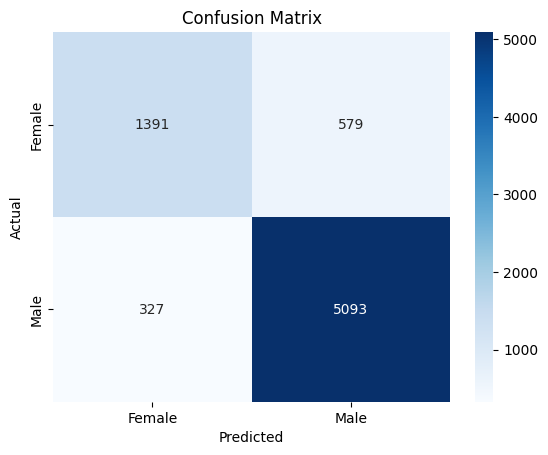

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


data_filtered = data[['Height', 'Weight', 'Age', 'Sport', 'Sex']].copy()

data_filtered['Sex'] = np.where(data_filtered['Sex'] == 'Male', 1, 0)

data_encoded = pd.get_dummies(data_filtered, columns=['Sport'], drop_first=True)

X = data_encoded.drop('Sex', axis=1)
y = data_encoded['Sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Female', 'Male']))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Wyraźnie jest niższy wynik prezycji oraz reszty metryk dla kobiet, prawdopodobnie spowodowane jest to nierównością w zbiorze danych; mężczyzn jest ok 2.5razy więcej. Można by sprowadzic metryki do prawie 100% dokładności gdyby uwzględnić 'Event', jako że większośc z nich (prawdopodobnie wszystkie) jest już podzielona na 'Male ...' 'Female ...' ale mijałoby się to trochę z celem.